In [1]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

In [2]:
conn = ps.connect(dbname="PROJE_TEST",
                  user="postgres",
                  password="340519",
                  port = "5432")

In [3]:
# MÜŞTERİ ANALİZİ 

In [4]:
# SQL sorgusunu tanımlayın
sql = """
--RFM--
-- Her müşteri için son sipariş tarihi, sipariş sayısı ve toplam harcama (amount) hesaplama
WITH customer_rfm AS (
    SELECT
        o.customer_id,
        MAX(o.order_date) AS last_order_date,
        COUNT(o.order_id) AS frequency,
        ROUND(SUM(d.quantity * d.unit_price)::NUMERIC, 2) AS monetary
    FROM
        orders o
JOIN order_details d ON o.order_id = d.order_id
    GROUP BY
        customer_id
),

-- Analiz tarihini verideki en son sipariş tarihinden bir gün sonrası olarak belirleme
reference_date AS (
    SELECT MAX(order_date) + INTERVAL '1 day' AS analysis_date FROM orders
),

-- Recency değerini gün cinsinden hesaplama ve RFM değerlerini bir araya getirme
rfm_values AS (
    SELECT
        c.customer_id,
        EXTRACT(day FROM (r.analysis_date - c.last_order_date)) AS recency,
        c.frequency,
        c.monetary,
        
        -- Recency Skoru
        CASE
            WHEN EXTRACT(day FROM (r.analysis_date - c.last_order_date)) <= 30 THEN 5
            WHEN EXTRACT(day FROM (r.analysis_date - c.last_order_date)) <= 60 THEN 4
            WHEN EXTRACT(day FROM (r.analysis_date - c.last_order_date)) <= 90 THEN 3
            WHEN EXTRACT(day FROM (r.analysis_date - c.last_order_date)) <= 120 THEN 2
            ELSE 1
        END AS r_score,
        
        -- Frequency Skoru
        CASE
            WHEN c.frequency >= 10 THEN 5
            WHEN c.frequency >= 7 THEN 4
            WHEN c.frequency >= 4 THEN 3
            WHEN c.frequency >= 2 THEN 2
            ELSE 1
        END AS f_score,
        
        -- Monetary Skoru
        CASE
            WHEN c.monetary >= 1000 THEN 5
            WHEN c.monetary >= 500 THEN 4
            WHEN c.monetary >= 250 THEN 3
            WHEN c.monetary >= 100 THEN 2
            ELSE 1
        END AS m_score
    FROM
        customer_rfm c
    CROSS JOIN
        reference_date r
)

-- RFM skorlarını birleştirme ve segment belirleme
SELECT
    customer_id,
    recency,
    frequency,
    monetary,
    r_score,
    f_score,
    m_score,
    
    -- RFM Skorunu birleştirme
      (r_score::TEXT) || (f_score::TEXT) || (m_score::TEXT) AS RFM_Score,

    -- Segment belirleme
    CASE
        WHEN (r_score = 5 AND f_score = 5 AND m_score = 5) THEN 'En İyi Müşteriler'
        WHEN r_score = 5 THEN 'Sadık Müşteriler'
        WHEN f_score = 5 THEN 'Potansiyel Müşteriler'
        WHEN m_score = 5 THEN 'Yüksek Değerli Müşteriler'
        WHEN r_score = 1 THEN 'Uyuyan Müşteriler'
        ELSE 'Diğer'
    END AS segment

FROM
    rfm_values;
"""

In [5]:
df = sqlio.read_sql_query(sql, conn)
df.head()

C:\Users\merve\AppData\Local\Temp\ipykernel_20812\2184680693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql, conn)


,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,TOMSP,45.0,14,4954.00,4,5,5,455,Potansiyel Müşteriler
1,LONEP,24.0,14,4258.60,5,5,5,555,En İyi Müşteriler
2,OLDWO,17.0,24,16325.15,5,5,5,555,En İyi Müşteriler
3,WARTH,22.0,37,16617.10,5,5,5,555,En İyi Müşteriler
4,MAGAA,52.0,21,7603.85,4,5,5,455,Potansiyel Müşteriler


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

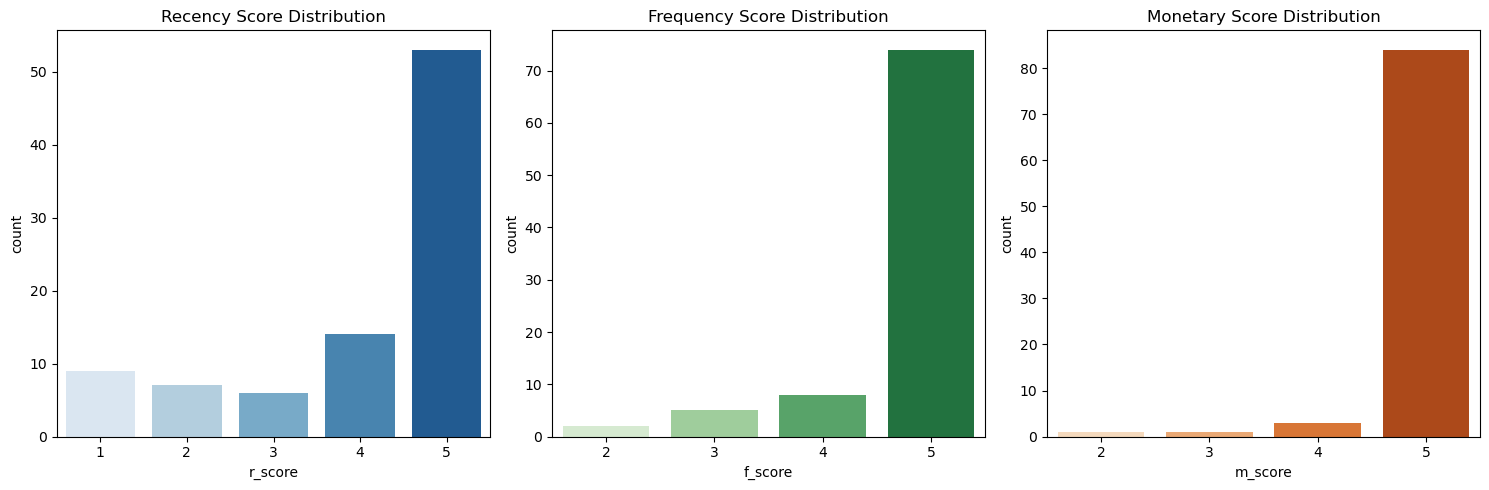

In [8]:
# Her bir RFM skorunun dağılımı
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='r_score', palette="Blues")
plt.title("Recency Score Distribution")

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='f_score', palette="Greens")
plt.title("Frequency Score Distribution")

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='m_score', palette="Oranges")
plt.title("Monetary Score Distribution")

plt.tight_layout()
plt.show()


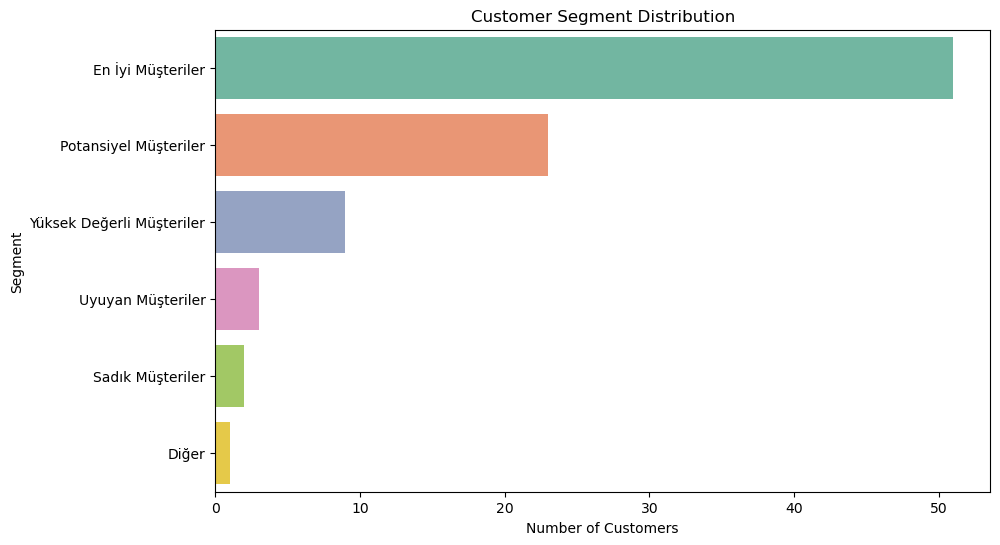

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="segment", order=df['segment'].value_counts().index, palette="Set2")
plt.title("Customer Segment Distribution")
plt.xlabel("Number of Customers")
plt.ylabel("Segment")
plt.show()


In [ ]:
# En İyi Müşteriler":Bu müşteriler düzenli, yüksek miktarda alışveriş yapan ve şirket için en değerli müşteriler.
# Potansiyel Müşteriler:Bu müşteriler,aktif bir şekilde alışveriş yapmayan ama şirketle etkileşim kurma olasılığı yüksek olan müşterilerdir. 
# Yüksek Değerli Müşteriler:Üçüncü sıradaki "Yüksek Değerli Müşteriler", şirket için önemli bir segmenttir. Bu müşteriler, genellikle alışveriş değerleri yüksek olan ama  sık alışveriş yapmayan bir gruptur.
# Uyuyan Müşteriler:Eskiden aktif olup artık alışveriş yapmayan müşterileri temsil ediyor. 
# Sadık Müşteriler:Düzenli alışveriş yapan, ancak alışveriş miktarları çok yüksek olmayan müşterilerdir. 
# Diğer:Bu kategori, belirsiz veya küçük sayıda müşteri grubunu içerebilir.

## Grfafik Yorumu ##
# Şirketin ana gelir kaynağı "En İyi Müşteriler" segmentinden geldiği görünüyor.Bu nedenle, bu grubun memnuniyetini ve bağlılığını sürdürmek kritik.
# Potansiyel Müşteriler" segmenti büyüme potansiyeli taşıyor ve doğru stratejilerle "En İyi Müşteriler" segmentine dönüştürülebilir.Bu gruba özel kampanyalar veya pazarlama stratejileri uygulanabilir.
# Daha küçük segmentler için kişiselleştirilmiş stratejiler uygulamak, müşteri tabanını genişletmek ve mevcut müşterilerden daha fazla değer elde etmek açısından etkili olabilir.

<Figure size 1200x600 with 0 Axes>

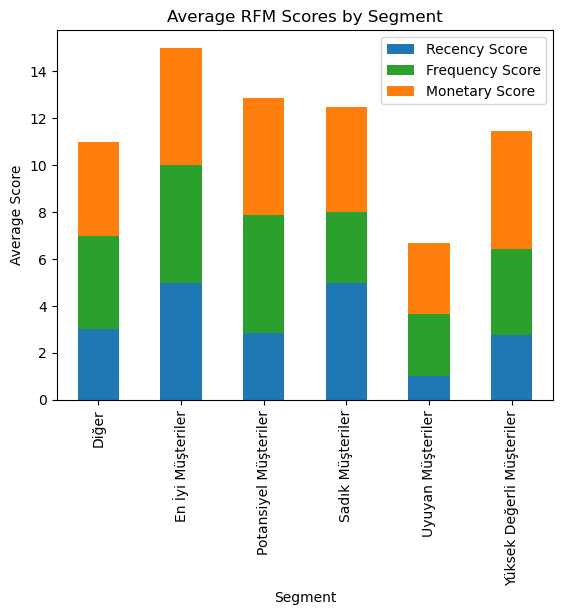

In [10]:
# Her segmentin ortalama RFM skorları
segment_analysis = df.groupby('segment')[['r_score', 'f_score', 'm_score']].mean().reset_index()

plt.figure(figsize=(12, 6))
segment_analysis.plot(kind='bar', x='segment', stacked=True, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.title("Average RFM Scores by Segment")
plt.xlabel("Segment")
plt.ylabel("Average Score")
plt.legend(["Recency Score", "Frequency Score", "Monetary Score"])
plt.show()


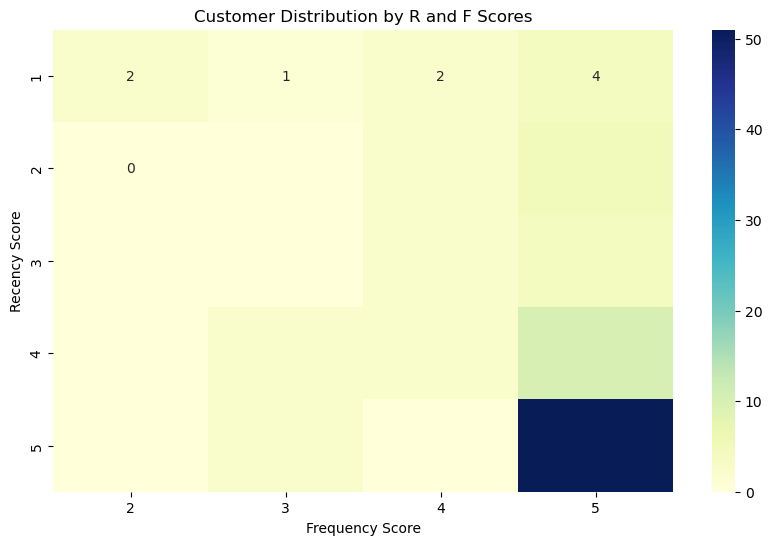

In [11]:
rfm_matrix = df.groupby(['r_score', 'f_score']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(rfm_matrix, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Customer Distribution by R and F Scores")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.show()


In [ ]:
# R = 5, F = 5 (En Değerli Müşteriler): Bu gruba yönelik özel kampanyalar, sadakat programları veya premium hizmetler sunulabilir.
# R = 1, F = 2 veya 3 (Uyuyan veya Kaybedilmiş Müşteriler): Bu müşterileri geri kazanmak için hatırlatma e-postaları, özel indirimler veya yeniden etkileşim kampanyaları yapılabilir.
# Orta Gruplar (R = 3-4, F = 3-4): Bu grup büyütülmeye çalışılabilir. Daha sık alışveriş yapmalarını teşvik etmek için kampanyalar yapılabilir.

In [12]:
# SİPARİŞ ANALİZİ

In [13]:
sql2 = """
-- 1. Yıllık Sipariş Sayısı
WITH yearly_orders AS (
    SELECT 
        EXTRACT(YEAR FROM order_date) AS order_year,
        COUNT(order_id) AS total_orders
    FROM 
        orders
    GROUP BY 
        order_year
),

-- 2. Kategori Bazında Sipariş Tutarı
category_order_amounts AS (
    SELECT
        EXTRACT(YEAR FROM o.order_date) AS order_year,
        c.category_name,
        ROUND(SUM(od.quantity * od.unit_price)::NUMERIC, 2) AS total_order_amount_excluding_discount,
        ROUND(SUM((od.quantity * od.unit_price) * (1 - od.discount))::NUMERIC, 2) AS total_order_amount_including_discount
    FROM 
        orders o
    JOIN 
        order_details od ON o.order_id = od.order_id
    JOIN
        products p ON od.product_id = p.product_id
    JOIN
        categories c ON p.category_id = c.category_id
    GROUP BY 
        order_year, c.category_name
),

-- 3. Sipariş Durumu Analizi
order_status_analysis AS (
    SELECT 
        EXTRACT(YEAR FROM o.order_date) AS order_year,
        o.order_id,
        o.order_date,
        o.required_date,
        o.shipped_date,
        CASE 
            WHEN o.shipped_date IS NOT NULL AND o.shipped_date <= o.required_date THEN 'Delivered On Time'
            WHEN o.shipped_date IS NOT NULL AND o.shipped_date > o.required_date THEN 'Late Delivery'
            WHEN o.shipped_date IS NULL AND CURRENT_DATE > o.required_date THEN 'Overdue'
            WHEN o.shipped_date IS NULL AND CURRENT_DATE <= o.required_date THEN 'Pending'
        END AS order_status
    FROM 
        orders o
)

-- Sonuçları birleştirerek çıktı alma
SELECT 
    yo.order_year AS order_year,
    yo.total_orders AS total_orders,
    coa.category_name AS category_name,
    coa.total_order_amount_excluding_discount AS total_order_amount_excluding_discount,
    coa.total_order_amount_including_discount AS total_order_amount_including_discount,
    osa.order_id AS order_id,
    osa.order_date AS order_date,
    osa.required_date AS required_date,
    osa.shipped_date AS shipped_date,
    osa.order_status AS order_status
FROM 
    yearly_orders yo
LEFT JOIN 
    category_order_amounts coa ON yo.order_year = coa.order_year
LEFT JOIN 
    order_status_analysis osa ON yo.order_year = osa.order_year;
"""



In [14]:
order_df = sqlio.read_sql_query(sql2, conn)
order_df.head()


C:\Users\merve\AppData\Local\Temp\ipykernel_18056\3369371085.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_df = sqlio.read_sql_query(sql2, conn)


,order_year,total_orders,category_name,total_order_amount_excluding_discount,total_order_amount_including_discount,order_id,order_date,required_date,shipped_date,order_status
0,1996.0,152,Beverages,53879.2,47919.00,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
1,1996.0,152,Condiments,19458.3,17900.38,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
2,1996.0,152,Confections,31511.6,29685.55,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
3,1996.0,152,Dairy Products,44615.8,40980.45,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
4,1996.0,152,Grains/Cereals,9817.6,9507.92,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time


In [15]:
order_df['order_date'] = pd.to_datetime(order_df['order_date'], errors='coerce')


In [16]:
order_df['order_year'] = order_df['order_date'].dt.year


In [17]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6640 entries, 0 to 6639
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   order_year                             6640 non-null   int32         
 1   total_orders                           6640 non-null   int64         
 2   category_name                          6640 non-null   object        
 3   total_order_amount_excluding_discount  6640 non-null   float64       
 4   total_order_amount_including_discount  6640 non-null   float64       
 5   order_id                               6640 non-null   int64         
 6   order_date                             6640 non-null   datetime64[ns]
 7   required_date                          6640 non-null   object        
 8   shipped_date                           6472 non-null   object        
 9   order_status                           6640 non-null   object  

In [18]:
order_df.head()

,order_year,total_orders,category_name,total_order_amount_excluding_discount,total_order_amount_including_discount,order_id,order_date,required_date,shipped_date,order_status
0,1996,152,Beverages,53879.2,47919.00,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
1,1996,152,Condiments,19458.3,17900.38,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
2,1996,152,Confections,31511.6,29685.55,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
3,1996,152,Dairy Products,44615.8,40980.45,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time
4,1996,152,Grains/Cereals,9817.6,9507.92,10248,1996-07-04,1996-08-01,1996-07-16,Delivered On Time


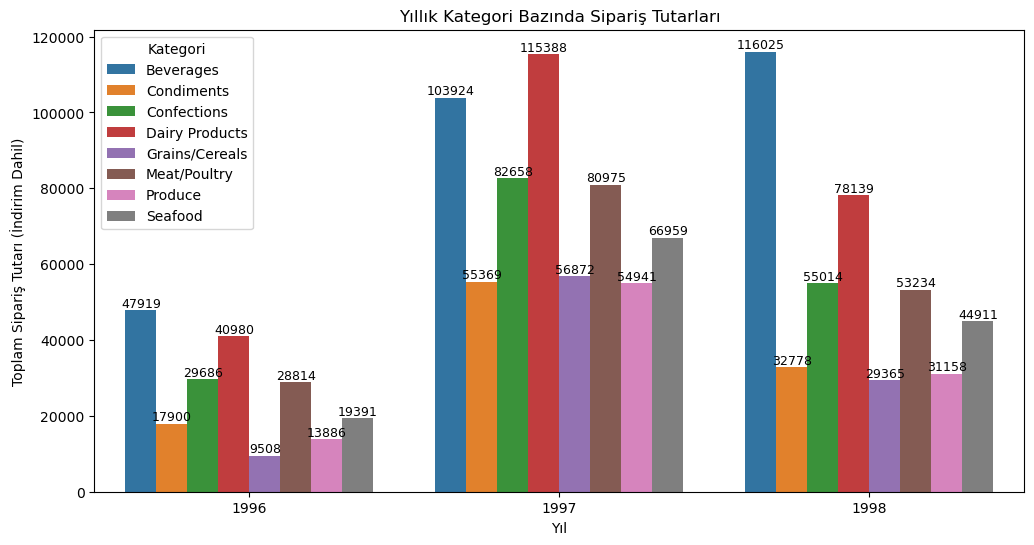

In [19]:
### 1. Kategori Bazında Sipariş Tutarını Görselleştirme

# Kategori bazında yıllık sipariş tutarlarını görselleştirme
plt.figure(figsize=(12, 6))
barplot=sns.barplot(data=order_df, x="order_year", y="total_order_amount_including_discount", hue="category_name")
for p in barplot.patches:
    barplot.annotate(
        f'{p.get_height():.0f}',  # Çubuğun yüksekliğini tam sayı olarak göster
        (p.get_x() + p.get_width() / 2, p.get_height()),  # X ve Y konumları
        ha='center', va='bottom', fontsize=9, color='black'  # Metin hizası ve stili
    )
plt.title("Yıllık Kategori Bazında Sipariş Tutarları")
plt.xlabel("Yıl")
plt.ylabel("Toplam Sipariş Tutarı (İndirim Dahil)")
plt.legend(title="Kategori")
plt.show()



In [ ]:
# Analizimizde ençok siparişi 1997 yılında alındığı gözlemlenmektedir. Yıl yıl kategori siparişleri incelendiğinde ise ençok kategori siparişi içecek, süt ürünleri ve şekerleme olduğunu görmekteyiz.

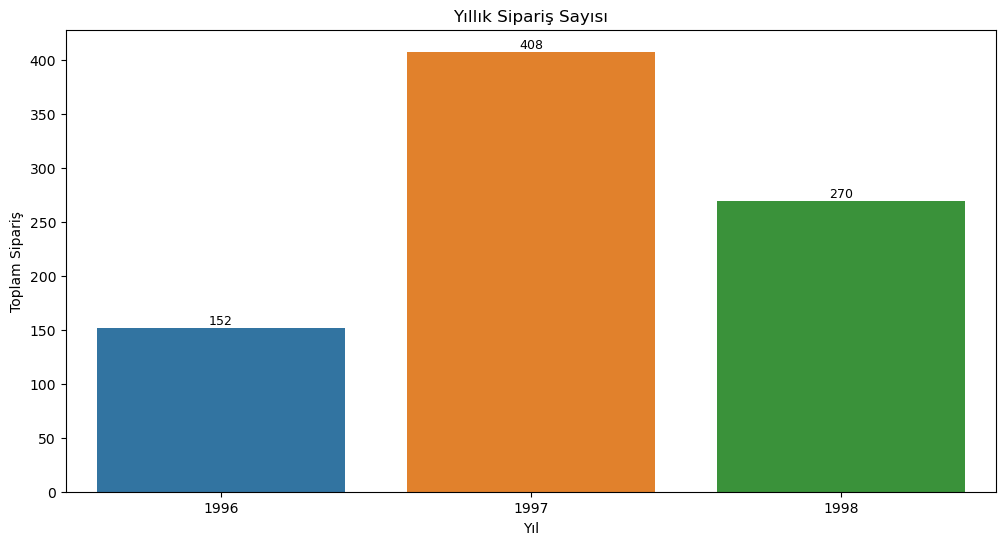

In [20]:
### 2. Yıllık Sipariş Sayısını Görselleştirme


df_yearly_orders = order_df.groupby("order_year")["total_orders"].first().reset_index()

# Sütun grafiği çizme
plt.figure(figsize=(12, 6))
barplot=sns.barplot(data=df_yearly_orders, x="order_year", y="total_orders")
for p in barplot.patches:
    barplot.annotate(
        f'{p.get_height():.0f}',  # Çubuğun yüksekliğini tam sayı olarak göster
        (p.get_x() + p.get_width() / 2, p.get_height()),  # X ve Y konumları
        ha='center', va='bottom', fontsize=9, color='black'  # Metin hizası ve stili
    )
plt.title("Yıllık Sipariş Sayısı")
plt.xlabel("Yıl")
plt.ylabel("Toplam Sipariş")
plt.show()


In [ ]:
# Yıllara göre genel sipariş durumuna bakıldığında 1996 dan 1997'ye geçişte artış gözlemlenmış fakat 1998 yılın siparişlerde azalma gözlenmiştir. Bunun sebebi müşterilerin siparişlerinde bir gecikme yaşaması veya farklı bir firma tercih etmiş olabilir.

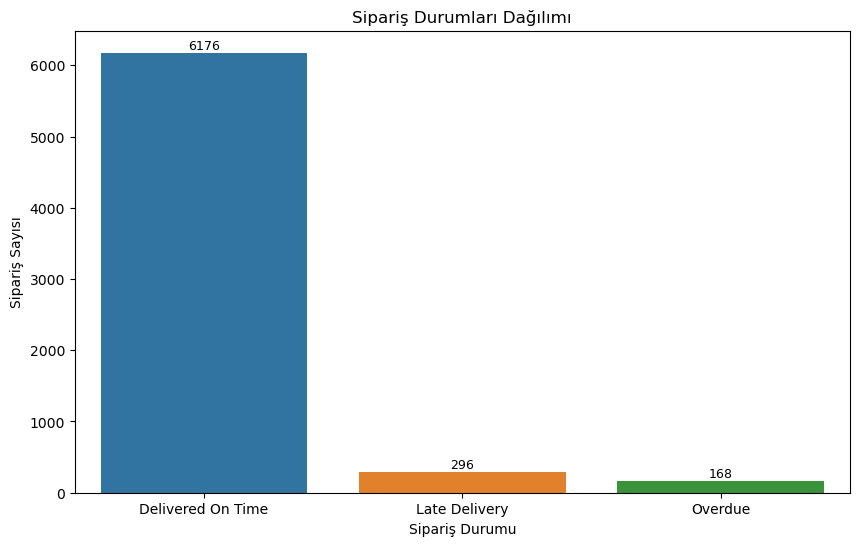

In [21]:
### 4. Sipariş Durumunu Analiz Etme

# Sipariş durumlarını analiz etme
plt.figure(figsize=(10, 6))
barplot=sns.countplot(data=order_df, x="order_status")
for p in barplot.patches:
    barplot.annotate(
        f'{p.get_height():.0f}',  # Çubuğun yüksekliğini tam sayı olarak göster
        (p.get_x() + p.get_width() / 2, p.get_height()),  # X ve Y konumları
        ha='center', va='bottom', fontsize=9, color='black'  # Metin hizası ve stili
    )
plt.title("Sipariş Durumları Dağılımı")
plt.xlabel("Sipariş Durumu")
plt.ylabel("Sipariş Sayısı")
plt.show()


In [ ]:
# Sipariş durumlarına baktığımızda siparişlerin çoğunun tam zamanında teslim edildiği gözlenmiştir. Fakat 168 siparişin teslim süresinin bir hayli gecikmiş olduğunu burda sipariş veren müşterilerin sipariş adetlerini düşürdüğü öne sürülebilir. 